# Mitochondria Displacement Plots
Script that goes through analyzed data and makes plots of mitochondria displacements
### File location parameters

In [1]:
analyzed_data_dir = '/Users/adam/Documents/SenseOfTouchResearch/SSN_ImageAnalysis/AnalyzedData/'

### Import packages

In [2]:
import yaml
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial import distance
import warnings
import glob
import numpy as np

### Functions for creating dataframes

In [3]:
def get_experiment_df(analyzed_data_dir):
    experiment_days = glob.iglob(analyzed_data_dir + '*')
    all_metadata = []
    for day in experiment_days:
        try:
            with open(day + '/metadata.yaml') as metadata_file:
                all_metadata.append(yaml.safe_load(metadata_file))
        except FileNotFoundError:
            pass

    metadata_df = pd.DataFrame(all_metadata)
    
    return metadata_df


def make_trial_df(experiment_id, all_metadata):
    metadata = all_metadata.loc[all_metadata['Experiment_id'] == experiment_id]
    mito_locations_file = analyzed_data_dir + experiment_id + '/trackpyBatchResults.yaml'
    with open(mito_locations_file, 'r') as yamlfile:
        mito_locations = yaml.safe_load(yamlfile)

    linked_mitos = pd.DataFrame.from_dict(mito_locations, orient='index')
    mito_locations = linked_mitos.loc[:, ['frame', 'particle', 'x', 'y', 'z']]
    
    mito_locations['pressure'] = mito_locations.apply(
        lambda row: get_pressure_this_mito(row), axis=1)
    
    mito_locations['x_rest'] = mito_locations.apply(
        lambda row: get_rest_location(row['particle'], 'x'), axis=1)
    mito_locations['y_rest'] = mito_locations.apply(
        lambda row: get_rest_location(row['particle'], 'y'), axis=1)
    mito_locations['z_rest'] = mito_locations.apply(
        lambda row: get_rest_location(row['particle'], 'z'), axis=1)

    return mito_locations


def make_mito_pair_df(mito_locations_df):
    mito_pairs_dicts = []
    for frame in mito_locations.frame.unique():
        this_frame = mito_locations.loc[(mito_locations['frame'] == frame)]
        this_frame.sort_values(by=['y'], inplace=True)
        this_frame.reset_index(inplace=True)
        # make dataframe of adjacent mitos
        for this_particle in range(mito_locations.particle.nunique() - 1):
            x_1 = this_frame.iloc[this_particle]['x']
            x_2 = this_frame.iloc[this_particle + 1]['x']
            x_dist = abs(x_2 - x_1)

            y_1 = this_frame.iloc[this_particle]['y']
            y_2 = this_frame.iloc[this_particle + 1]['y']
            y_dist = abs(y_2 - y_1)

            z_1 = this_frame.iloc[this_particle]['z']
            z_2 = this_frame.iloc[this_particle + 1]['z']
            z_dist = abs(z_2 - z_1)

            total_dist = distance.euclidean([x_1, y_1, z_1], [x_2, y_2, z_2])

            particle_1 = int(this_frame.iloc[this_particle]['particle'])
            particle_2 = int(this_frame.iloc[this_particle + 1]['particle'])

            mito_pairs_dicts.append({'x_dist': x_dist, 'x_1': x_1, 'x_2': x_2,
                                     'y_dist': y_dist, 'y_1': y_1, 'y_2': y_2,
                                     'z_dist': z_dist, 'z_1': z_1, 'z_2': z_2,
                                     'particle_1': particle_1,
                                     'particle_2': particle_2,
                                     'total_dist': total_dist, 'frame': frame,
                                     'pair_id': this_particle})

    mito_pairs = pd.DataFrame(mito_pairs_dicts)
    mito_pairs['pressure'] = mito_pairs.apply(lambda row: get_pressure_this_mito(row), axis=1)
    
    mito_pairs['rest_dist'] = mito_pairs.apply(
        lambda pair: get_rest_distance(pair['pair_id'], 'euclid'), axis=1)
    mito_pairs['x_rest_dist'] = mito_pairs.apply(
        lambda pair: get_rest_distance(pair['pair_id'], 'x'), axis=1)
    mito_pairs['y_rest_dist'] = mito_pairs.apply(
        lambda pair: get_rest_distance(pair['pair_id'], 'y'), axis=1)
    mito_pairs['z_rest_dist'] = mito_pairs.apply(
        lambda pair: get_rest_distance(pair['pair_id'], 'z'), axis=1)

    mito_pairs['strain'] = ((mito_pairs['total_dist'] - mito_pairs['rest_dist'])
                        / mito_pairs['rest_dist'])
    mito_pairs['x_strain'] = ((mito_pairs['x_dist'] - mito_pairs['x_rest_dist'])
                          / mito_pairs['x_rest_dist'])
    mito_pairs['y_strain'] = ((mito_pairs['y_dist'] - mito_pairs['y_rest_dist'])
                          / mito_pairs['y_rest_dist'])
    mito_pairs['z_strain'] = ((mito_pairs['z_dist'] - mito_pairs['z_rest_dist'])
                          / mito_pairs['z_rest_dist'])

    return mito_pairs

### Functions for manipulating dataframes

In [4]:
def calc_x_distance(row):
    return distance.euclidean([row['x']], [row['x_rest']])

def calc_xz_distance(row):
    return distance.euclidean([row['x'], row['z']], [row['x_rest'], row['z_rest']])

def calc_xyz_distance(row):
    return distance.euclidean([row['x'], row['y'], row['z']], [row['x_rest'],  row['y_rest'], row['z_rest']])

### Function for plotting

In [5]:
def plot_strain_centered_on_actuator(strain_df: pd.DataFrame,
                                   linked_mitos_df: pd.DataFrame,
                                   metadata_df: pd.DataFrame) -> pd.DataFrame:
    actuator_center_coords = metadata_df['actuator_center'].apply(pd.Series).stack()
#     temp_dict = []
#         for i in range(len(strain)):
#             for j in range(len(strain[0])):
#                 temp_dict.append({'strain': strain[i][j],
#                                   'ycoords': ycoords[i][j],
#                                   'pressure': pressure[i],
#                                   'stack_num': i})
#                 index += 1   
    y_vals = []
    for index, row in strain_df.iterrows():
        particle = row['particle_1']
        frame = row['frame']
        
        y_vals.append(float(linked_mitos_df.loc[(linked_mitos_df['particle'] == particle) &
                                    (linked_mitos_df['frame'] == frame)]['y']) - actuator_center_coords[1])
    strain_df['y_vals'] = pd.Series(y_vals)

    fig, ax = plt.subplots()
    strain_df.loc[strain_df['pressure'] == 0].groupby(['frame']).plot(
                x='y_vals', y='strain',
                color='red', drawstyle="steps", ax=ax)
    strain_df.loc[strain_df['pressure'] == 300].groupby(['frame']).plot(
                x='y_vals', y='strain',
                color='green', drawstyle="steps", ax=ax)
    
def plot_disp_centered_on_actuator(linked_mitos_df: pd.DataFrame,
                                   metadata_df: pd.DataFrame,
                                   axes: str) -> pd.DataFrame:
    actuator_center_coords = metadata_df['actuator_center'].apply(pd.Series).stack()
    linked_mitos_df['corrected_y'] = linked_mitos_df['y'] - actuator_center_coords[1]
    linked_mitos_df['x_disp'] = linked_mitos_df.apply(calc_x_distance, axis=1)
    linked_mitos_df['xz_disp'] = linked_mitos_df.apply(calc_xz_distance, axis=1)
    linked_mitos_df['xyz_disp'] = linked_mitos_df.apply(calc_xyz_distance, axis=1)
    
    plot_vals = axes + '_disp'
    
    fig, ax = plt.subplots()
    linked_mitos_df.loc[linked_mitos_df['pressure'] == 0].groupby(['frame']).plot(
                x='corrected_y', y=plot_vals,
                color='red', kind='scatter', ax=ax)
    linked_mitos_df.loc[linked_mitos_df['pressure'] == 300].groupby(['frame']).plot(
                x='corrected_y', y=plot_vals,
                color='green', kind='scatter', ax=ax)

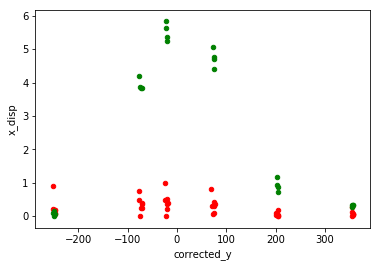

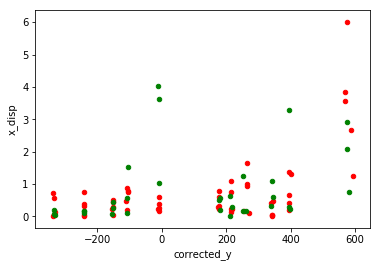

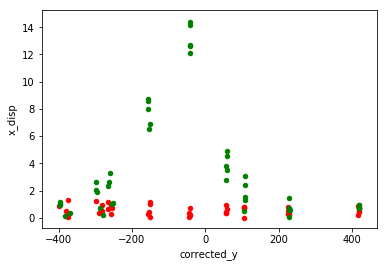

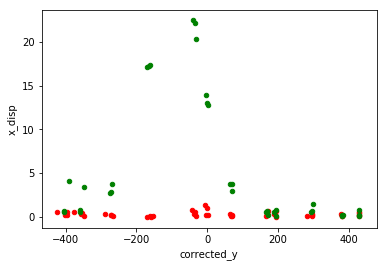

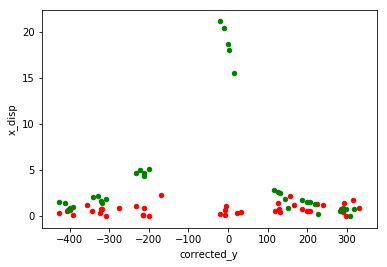

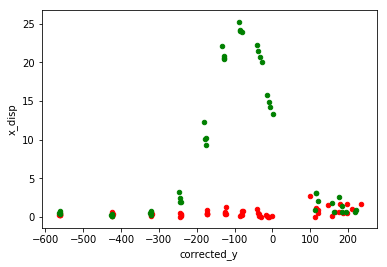

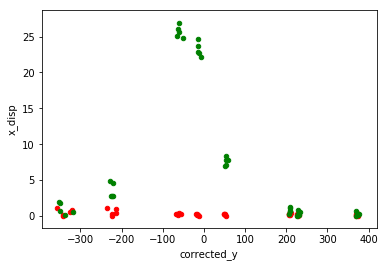

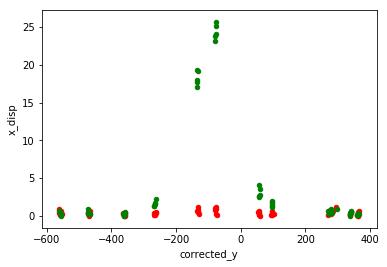

In [6]:
# get all the metadata
all_metadata = get_experiment_df(analyzed_data_dir)
# filter out trials we don't want
trials_with_strain_and_actuator = all_metadata.loc[(all_metadata['analysis_status'] == 'Strain calculated') & (all_metadata['actuator_center'].notnull())]
# make plots for those trials
for index, row in trials_with_strain_and_actuator.iterrows():
    experiment_id = row['Experiment_id']
    metadata = trials_with_strain_and_actuator.loc[all_metadata['Experiment_id'] == experiment_id]

    strain_file = analyzed_data_dir + experiment_id + '/strain.yaml'
    with open(strain_file, 'r') as yamlfile:
        strain_df = yaml.safe_load(yamlfile)
    strain_df = pd.DataFrame(strain_df)

    linked_mitos_file = analyzed_data_dir + experiment_id + '/mito_locations.yaml'
    with open(linked_mitos_file, 'r') as yamlfile:
        linked_mitos_df = yaml.safe_load(yamlfile)
    linked_mitos_df = pd.DataFrame.from_dict(linked_mitos_df)

    plot_disp_centered_on_actuator(linked_mitos_df, metadata, 'x')
#     plot_disp_centered_on_actuator(linked_mitos_df, metadata, 'xz')
#     plot_disp_centered_on_actuator(linked_mitos_df, metadata, 'xyz')


## Testing functions to make sure analysis works properly

In [8]:
# import unittest

# class TestDataframeBuilders(unittest.TestCase):
        
#     def setUp(self):
#         self.analyzed_data_dir = '/Users/adam/Documents/SenseOfTouchResearch/SSN_ImageAnalysis/AnalyzedData/'
#         self.all_metadata = get_experiment_df(self.analyzed_data_dir)
#         self.test_cases = 'SSN_120_001'

#     def test_make_trial_df(self):
#         for exp_id in self.test_cases:
#             this_trial_mitos = make_trial_df(exp_id, self.all_metadata)
            




# unittest.main(argv=[''], verbosity=2, exit=False)